# Tensorflow-quantum demo

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy

seed = np.random.seed(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

EPOCHS = 20
BATCH_SIZE = 25
LEARNING_RATE = 0.05
N_LAYERS = 3

2022-12-01 12:22:00.004091: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 12:22:01.405681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12025 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:17:00.0, compute capability: 8.0
2022-12-01 12:22:01.407590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21037 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0
2022-12-01 12:22:01.409419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 

## Initialise random datasat

In [2]:
from sklearn.datasets import make_classification

n_features = 5
X, Y = make_classification(n_samples=100, n_features=n_features, n_redundant=0,
                             n_informative=n_features, n_clusters_per_class=1,
                             random_state=1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
X = scaler.fit_transform(X)

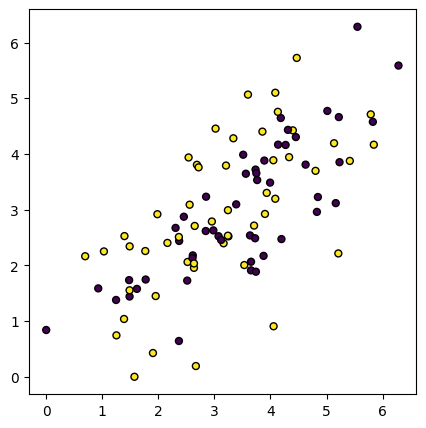

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], marker="o", c=Y, s=25, edgecolor="k");

## Create ansatz

In [4]:
## create ansatz circuit
qubits = cirq.LineQubit.range(n_features)

n_layers = N_LAYERS
enc_syms = sympy.symbols(f'enc0:{n_features}')
input_layer_symbols = [str(s) for s in enc_syms]
num_pqc_syms = n_features*n_layers
pqc_syms = sympy.symbols(f'pqc0:{num_pqc_syms}')
pqc_symbols = [str(s) for s in pqc_syms]


def enc_circuit(qubits):
    c = cirq.Circuit()
    # Encoding
    for i in range(len(qubits)):
        c += cirq.rx(enc_syms[i]).on(qubits[i])
    return c

def pqc_circuit(qubits):
    # PQC
    c = cirq.Circuit()
    c += cirq.H.on_each(qubits)
    symbols = []
    for layer in range(n_layers):
        for i in range(len(qubits)):
            sym = pqc_syms[len(qubits)*layer + i]
            c += cirq.rz(sym).on(qubits[i]).controlled_by(qubits[(i+1)%len(qubits)])
        c += cirq.H.on_each(qubits)
    return c

input_layer_cirq = enc_circuit(qubits)
pqc_cirq = pqc_circuit(qubits)
full_circuit = input_layer_cirq + pqc_cirq
SPSB_EPOCHS = ((4*len(pqc_syms)+1)//3)*EPOCHS
init_params = np.random.uniform(high=2*np.pi, size=n_layers*n_features)
full_circuit

┌─────────┐                                                   ┌─────────┐                                                       ┌──────────┐
0: ───Rx(enc0)───H───Rz(pqc0)─────────────────────────────────────@────────────H───Rz(pqc5)─────────────────────────────────────@────────────H───Rz(pqc10)────────────────────────────────────────@─────────────H───
                     │                                            │                │                                            │                │                                                │
1: ───Rx(enc1)───H───@──────────Rz(pqc1)───H──────────────────────┼────────────────@──────────Rz(pqc6)───H──────────────────────┼────────────────@───────────Rz(pqc11)───H────────────────────────┼─────────────────
                                │                                 │                           │                                 │                            │                                    │
2: ───Rx(enc2)───H──────────────@──────────Rz(pqc2)───H───────────┼───────────────────────────@──────────Rz(pqc7)───H───────────┼────────────────────────────@───────────Rz(pqc12)───H────────────┼─────────────────
                                           │                      │                                      │                      │                                        │                        │
3: ───Rx(enc3)───H─────────────────────────@──────────Rz(pqc3)────┼───────H──────────────────────────────@──────────Rz(pqc8)────┼───────H────────────────────────────────@───────────Rz(pqc13)────┼────────H────────
                                                      │           │                                                 │           │                                                    │            │
4: ───Rx(enc4)───H────────────────────────────────────@───────────Rz(pqc4)─────H────────────────────────────────────@───────────Rz(pqc9)─────H───────────────────────────────────────@────────────Rz(pqc14)─────H───
                                                                 └─────────┘                                                   └─────────┘                                                       └──────────┘

## Setup hybrid-model with parameter shift rule

In [5]:
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq

class HybridModel(tf.keras.models.Model):
    def __init__(self, input_layer, input_symbols, pqc, pqc_params=None):
        super(HybridModel, self).__init__()
        self.input_symbols = input_symbols
        self.input_layer = tfq.convert_to_tensor([input_layer])
        self.pqc = pqc
        self.readout_ops = [cirq.Z(q) for q in self.pqc.all_qubits()]
        self.qmodel = tfq.layers.PQC(
            self.pqc,
            self.readout_ops,
            initializer=tf.keras.initializers.RandomUniform(0, 2*np.pi),
            differentiator=tfq.differentiators.ParameterShift()
        )
        if pqc_params is not None:
            self.qmodel.set_weights([pqc_params])
        self.fc = tf.keras.layers.Dense(1)

    def call(self, inputs):
        num_batch = tf.gather(tf.shape(inputs), 0)    # Get batch size: first element of shape
        # (1, 1) -> (batch, 1)
        input_circuits = tf.repeat(self.input_layer, repeats=num_batch)
        inp = tfq.resolve_parameters(input_circuits,
                       symbol_names=self.input_symbols,
                       symbol_values=tf.convert_to_tensor(inputs))
        out = self.qmodel(inp)
        out = self.fc(out)
        return tf.sigmoid(out)

model = HybridModel(input_layer_cirq, input_layer_symbols, pqc_cirq, pqc_params = init_params)
tf.random.set_seed(1234)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), metrics='accuracy')
loss_init, acc_init = model.evaluate(X, Y, batch_size=len(X))

1/1 [==============================] - 2s 2s/step - loss: 0.7173 - accuracy: 0.4000


## Fit the model

In [6]:
hist_pmshift = model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
hist_pmshift.history['loss'] = [loss_init] + hist_pmshift.history['loss']
hist_pmshift.history['accuracy'] = [acc_init] + hist_pmshift.history['accuracy']

2022-12-01 12:22:06.036301: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
# check some outputs
for y_hat, y in zip(model(X)[:5], Y[:5]):
    print(y_hat.numpy(), y)

[0.87651557] 1
[0.9369231] 1
[0.13453421] 0
[0.13017288] 0
[0.4643238] 0


In [8]:
model.qmodel.parameters

<tf.Variable 'parameters:0' shape=(15,) dtype=float32, numpy=
array([1.0713527 , 0.03358627, 3.5201547 , 0.2752996 , 3.2114878 ,
       2.7501528 , 2.9314957 , 1.3450505 , 3.922388  , 3.7189832 ,
       5.9008913 , 4.8924055 , 4.6175694 , 5.9411826 , 0.09267614],
      dtype=float32)>

## Setup hybrid-model with SPSB

In [9]:
import tensorflow as tf
import tensorflow_quantum as tfq
from math import log

exp_layer = tfq.layers.Expectation()

EPSILON = 0.01

@tf.function
@tf.custom_gradient
def get_expectations(symbol_values, circuit, readout_ops, symbol_names):
    """This is the custom expectations function with SPSB gradients"""
    def get_expectations_helper(x):
        # Use state simulator at the moment, could also be sampled
        batch_size = circuit.shape[0]
        res = exp_layer(circuit,
                        operators = tf.repeat(
                            tf.expand_dims(readout_ops,axis=0),
                            batch_size,
                            axis=0),
                        symbol_names = symbol_names,
                        symbol_values = x)
        return res

    def grad(upstream):
        # x_length = symbol_values.shape[0]
        delta = np.random.choice([-1, 1], size=symbol_values.shape)
        delta = EPSILON * tf.convert_to_tensor(delta, dtype=tf.float32)
        xplus = symbol_values + delta
        xminus = symbol_values - delta
        cminus = get_expectations_helper(xminus)
        cplus = get_expectations_helper(xplus)
        f_prime = cplus - cminus
        jacobian = tf.einsum('bm,bn->bmn', f_prime, 1/(2*delta))  # batched outer product
        out = tf.einsum('bm,bmn->bn', upstream, jacobian)  # batched vector Jacobian product
        return (out, None, None, None)

    return get_expectations_helper(symbol_values), grad

In [10]:
import numpy as np

class HybridModelSPSB(tf.keras.models.Model):
    def __init__(self, input_layer, input_symbols, pqc, pqc_symbols):
        super(HybridModelSPSB, self).__init__()
        self.input_symbols = input_symbols
        self.input_layer = tfq.convert_to_tensor([input_layer])
        self.pqc = tfq.convert_to_tensor([pqc])
        self.pqc_symbols = tf.constant(pqc_symbols)
        self.params = tf.Variable(
            np.random.uniform(high=2*np.pi,
            size = (len(pqc_symbols))),
            trainable = True,
            dtype=tf.float32
        )
        self.readout_ops = tfq.convert_to_tensor([cirq.Z(q) for q in pqc.all_qubits()])
        self.fc = tf.keras.layers.Dense(1)
    
    def call(self, inputs):
        num_batch = tf.gather(tf.shape(inputs), 0)    # Get batch size: first element of shape
        # (1, 1) -> (batch, 1)
        input_circuits = tf.repeat(self.input_layer, repeats=num_batch)
        inp = tfq.resolve_parameters(input_circuits,
                       symbol_names=self.input_symbols,
                       symbol_values=tf.convert_to_tensor(inputs))
        
        symbol_values = tf.repeat(tf.expand_dims(self.params,axis=0), num_batch, axis=0)
        out = get_expectations(
            symbol_values,
            inp + self.pqc,
            self.readout_ops,
            self.pqc_symbols
        )
        out = self.fc(out)
        return tf.sigmoid(out)

spsb_model = HybridModelSPSB(input_layer_cirq, input_layer_symbols, pqc_cirq, pqc_symbols)
spsb_model.params = tf.Variable(tf.convert_to_tensor(init_params, dtype=tf.float32), trainable=True)
spsb_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), metrics='accuracy', run_eagerly=True)
loss_init, acc_init = spsb_model.evaluate(X, Y, batch_size=len(X))

1/1 [==============================] - 0s 149ms/step - loss: 0.7133 - accuracy: 0.4400


## Fit the model

In [11]:
loss_init, acc_init = spsb_model.evaluate(X, Y, batch_size=len(X))
hist_spsb = spsb_model.fit(X, Y, epochs=SPSB_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
hist_spsb.history['loss'] = [loss_init] + hist_spsb.history['loss']
hist_spsb.history['accuracy'] = [acc_init] + hist_spsb.history['accuracy']

1/1 [==============================] - 0s 93ms/step - loss: 0.7133 - accuracy: 0.4400


In [12]:
# calculate the circuit evaluations per epoch
circ_evals_pmshift = len(X) * (4 * len(pqc_syms)+1) * np.arange(EPOCHS+1)
circ_evals_spsb = len(X) * (2 + 1) * np.arange(SPSB_EPOCHS+1)

## Plot the results

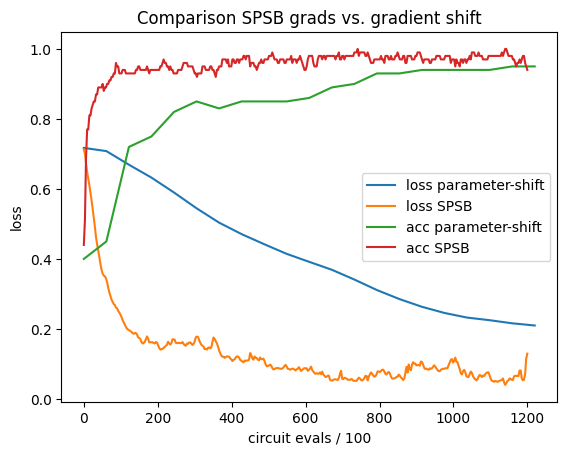

In [13]:
import matplotlib.pyplot as plt
plt.plot(circ_evals_pmshift/100 ,hist_pmshift.history['loss'], label='loss parameter-shift')
plt.plot(circ_evals_spsb/100 ,hist_spsb.history['loss'], label='loss SPSB')
plt.plot(circ_evals_pmshift/100 ,hist_pmshift.history['accuracy'], label='acc parameter-shift')
plt.plot(circ_evals_spsb/100 ,hist_spsb.history['accuracy'], label='acc SPSB')
plt.title('Comparison SPSB grads vs. gradient shift')
plt.xlabel('circuit evals / 100')
plt.ylabel('loss')
plt.legend();